# Exploration 노드 16

## 라이브러리 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

## 데이터 불러오기

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.reset_index(inplace=True) # 인덱스 reset
data

,index,UserId,ItemId,Rating,Time
0,31,1,3186,4,978300019
1,22,1,1270,5,978300055
2,27,1,1721,4,978300055
3,37,1,1022,5,978300055
4,24,1,2340,3,978300103
...,...,...,...,...,...
1000204,1000019,6040,2917,4,997454429
1000205,999988,6040,1921,4,997454464
1000206,1000172,6040,1784,3,997454464
1000207,1000167,6040,161,3,997454486


Time에 대한 데이터가 timestamp의 형태로 저장이 되었는데, 이는 처리가 너무 불편하기 때문에 datetime의 형태로 바꾸어준다. 

In [4]:
# Timestamp를 DateTime으로 변환
data['Time'] = data['Time'].apply(lambda x: datetime.fromtimestamp(x))
data.head()

,index,UserId,ItemId,Rating,Time
0,31,1,3186,4,2000-12-31 22:00:19
1,22,1,1270,5,2000-12-31 22:00:55
2,27,1,1721,4,2000-12-31 22:00:55
3,37,1,1022,5,2000-12-31 22:00:55
4,24,1,2340,3,2000-12-31 22:01:43


### EDA 및 전처리

In [5]:
# 유저 수와 영화 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### Session 새로 정의
우리에게 주어진 정보는 session_id가 아닌 user_id이다. 한 User가 여러 Session에 걸쳐서 리뷰를 입력해왔을 수 있기 때문에 한 Session의 단위시간을 정해서 Session을 새로 정의해주어야 한다. 그러기 위해서 데이터를 자세하게 확인해볼 필요가 있다. 

In [6]:
# User별 리뷰 개수
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
# user의 리뷰 개수의 중앙값과 평균
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [8]:
# user의 리뷰 개수의 최솟값과 최댓값
user_length.min(), user_length.max()

(20, 2314)

In [9]:
user_length.quantile(0.999)

1343.181000000005

User별 리뷰의 개수에 대한 정보는 위와 같다. 또한 리뷰 개수의 최댓값은 2314개이지만, 1343개 이하로 전체의 0.999가 포함되는 것을 확인할 수 있다.  
  
하지만 리뷰의 개수가 굉장히 많은 경우도 존재하는 것으로 보아, 역시 __User가 한 Session 안에 모든 리뷰를 올린 게 아닐 확률이 높다__. 그렇기 때문에 Session을 새로 정의해서 나누어야 하는데, 우선 __시간에 따른 User의 리뷰 입력 양상__을 확인해보면 Session의 시간을 정하는 데 도움이 될 것이라고 예상이 된다.

In [10]:
# 첫 번째 User의 데이터 확인
first = data[data['UserId']==1]

In [11]:
time_first=pd.Series(first['Time']).reset_index(drop=True)
time_first.value_counts()

2001-01-06 23:37:48    5
2001-01-06 23:38:11    3
2000-12-31 22:00:55    3
2000-12-31 22:12:40    3
2000-12-31 22:29:37    3
2000-12-31 22:37:48    2
2000-12-31 22:36:45    2
2000-12-31 22:33:59    2
2000-12-31 22:29:13    2
2000-12-31 22:34:51    2
2000-12-31 22:11:59    2
2001-01-06 23:38:50    2
2000-12-31 22:35:24    1
2000-12-31 22:38:01    1
2000-12-31 22:36:28    1
2000-12-31 22:36:14    1
2001-01-06 23:35:39    1
2001-01-06 23:36:35    1
2000-12-31 22:35:49    1
2000-12-31 22:00:19    1
2000-12-31 22:32:48    1
2000-12-31 22:35:09    1
2000-12-31 22:32:33    1
2000-12-31 22:29:12    1
2000-12-31 22:28:33    1
2000-12-31 22:26:59    1
2000-12-31 22:26:30    1
2000-12-31 22:26:10    1
2000-12-31 22:23:18    1
2000-12-31 22:22:48    1
2000-12-31 22:04:35    1
2000-12-31 22:02:52    1
2000-12-31 22:01:43    1
2001-01-06 23:39:11    1
Name: Time, dtype: int64

한번에 여러 리뷰를 입력하기도 했다는 것을 알 수 있다. 하지만 한번에 여러 리뷰를 입력한 경우는 비교적 적은 것으로 보이기 때문에, 입력한 시간이 어떻게 되는지 다시 확인해보겠다. 

(array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.]),
 array([11322.91688657, 11323.52375231, 11324.13061806, 11324.7374838 ,
        11325.34434954, 11325.95121528, 11326.55808102, 11327.16494676,
        11327.7718125 , 11328.37867824, 11328.98554398]),
 <BarContainer object of 10 artists>)

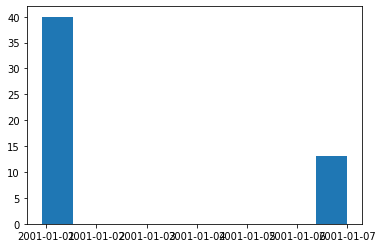

In [12]:
plt.hist(time_first)

In [13]:
date_first = time_first.apply(lambda x: x.date())
date_first.value_counts()

2000-12-31    40
2001-01-06    13
Name: Time, dtype: int64

In [14]:
time_first[:40]

0    2000-12-31 22:00:19
1    2000-12-31 22:00:55
2    2000-12-31 22:00:55
3    2000-12-31 22:00:55
4    2000-12-31 22:01:43
5    2000-12-31 22:02:52
6    2000-12-31 22:04:35
7    2000-12-31 22:11:59
8    2000-12-31 22:11:59
9    2000-12-31 22:12:40
10   2000-12-31 22:12:40
11   2000-12-31 22:12:40
12   2000-12-31 22:22:48
13   2000-12-31 22:23:18
14   2000-12-31 22:26:10
15   2000-12-31 22:26:30
16   2000-12-31 22:26:59
17   2000-12-31 22:28:33
18   2000-12-31 22:29:12
19   2000-12-31 22:29:13
20   2000-12-31 22:29:13
21   2000-12-31 22:29:37
22   2000-12-31 22:29:37
23   2000-12-31 22:29:37
24   2000-12-31 22:32:33
25   2000-12-31 22:32:48
26   2000-12-31 22:33:59
27   2000-12-31 22:33:59
28   2000-12-31 22:34:51
29   2000-12-31 22:34:51
30   2000-12-31 22:35:09
31   2000-12-31 22:35:24
32   2000-12-31 22:35:49
33   2000-12-31 22:36:14
34   2000-12-31 22:36:28
35   2000-12-31 22:36:45
36   2000-12-31 22:36:45
37   2000-12-31 22:37:48
38   2000-12-31 22:37:48
39   2000-12-31 22:38:01


2000년 12월 31일 하루동안 입력한 리뷰가 대략 40분 조금 안 되는 시간에 걸쳐 한번에 입력한 것으로 보인다.  
첫 번째 User가 특별한 케이스였을 수도 있으니 두 번째 User도 확인해보겠다. 

In [15]:
# 두 번째 User의 데이터 확인
second = data[data['UserId']==2]

In [16]:
time_second=pd.Series(second['Time']).reset_index(drop=True)
time_second.value_counts()

2000-12-31 21:56:49    6
2000-12-31 22:00:02    6
2000-12-31 21:57:19    5
2000-12-31 22:02:54    4
2000-12-31 21:56:13    4
                      ..
2000-12-31 21:46:13    1
2000-12-31 21:47:00    1
2000-12-31 21:47:30    1
2000-12-31 21:47:49    1
2000-12-31 21:45:43    1
Name: Time, Length: 66, dtype: int64

두 번째 유저도 한번에 여러 리뷰를 입력한 경우가 있다는 것을 알 수 있다. 하지만 이전과 같이, 그 비율이 적다.  

(array([ 5., 11., 13., 17., 10., 12.,  5.,  9., 27., 20.]),
 array([11322.8949537 , 11322.89732639, 11322.89969907, 11322.90207176,
        11322.90444444, 11322.90681713, 11322.90918981, 11322.9115625 ,
        11322.91393519, 11322.91630787, 11322.91868056]),
 <BarContainer object of 10 artists>)

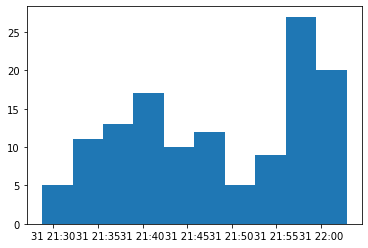

In [17]:
plt.hist(time_second)

In [18]:
date_second = time_second.apply(lambda x: x.date())
date_second.value_counts()

2000-12-31    129
Name: Time, dtype: int64

In [19]:
time_second[:118]

0     2000-12-31 21:28:44
1     2000-12-31 21:29:11
2     2000-12-31 21:29:11
3     2000-12-31 21:29:56
4     2000-12-31 21:31:01
              ...        
113   2000-12-31 22:00:02
114   2000-12-31 22:00:02
115   2000-12-31 22:00:25
116   2000-12-31 22:00:25
117   2000-12-31 22:00:51
Name: Time, Length: 118, dtype: datetime64[ns]

두 번째 User는 하루동안 129개의 리뷰를 남겼고, 그래프에서 확인할 수 있듯이 대략 2시간이 안 되는 시간동안 꾸준히 리뷰를 남겼다는 것을 알 수 있다. 마지막으로 세번 째 User까지만 확인하고 Session을 정의하겠다. 

In [20]:
# 세 번째 User의 데이터 확인
third = data[data['UserId']==3]

In [21]:
time_third=pd.Series(third['Time']).reset_index(drop=True)
time_third.value_counts()

2000-12-31 21:20:00    3
2000-12-31 21:19:30    3
2000-12-31 21:22:37    3
2000-12-31 21:16:59    3
2000-12-31 21:29:07    3
2000-12-31 21:24:27    2
2000-12-31 21:23:57    2
2000-12-31 21:31:36    2
2000-12-31 21:21:03    2
2000-12-31 21:22:57    2
2000-12-31 21:18:59    2
2000-12-31 21:33:50    2
2000-12-31 21:34:46    2
2000-12-31 21:11:35    2
2000-12-31 21:11:08    2
2000-12-31 21:31:56    1
2000-12-31 21:34:19    1
2000-12-31 21:30:31    1
2000-12-31 21:30:01    1
2000-12-31 21:29:26    1
2000-12-31 21:10:18    1
2000-12-31 21:28:23    1
2000-12-31 21:27:59    1
2000-12-31 21:23:25    1
2000-12-31 21:10:39    1
2000-12-31 21:21:50    1
2000-12-31 21:21:30    1
2000-12-31 21:18:32    1
2000-12-31 21:17:19    1
2000-12-31 21:16:36    1
2000-12-31 21:35:04    1
Name: Time, dtype: int64

세 번째 유저도 한번에 여러 리뷰를 입력한 경우가 있다는 것을 알 수 있다. 하지만 첫 번째와 두 번째의 User와 같이 그 비율이 적기 때문에 한번에 여러 리뷰를 남긴 경우만 Session으로 치는 것은 __바람직하지 않아 보인다__.   

(array([6., 0., 5., 9., 7., 7., 0., 7., 4., 6.]),
 array([11322.88215278, 11322.88387269, 11322.88559259, 11322.8873125 ,
        11322.88903241, 11322.89075231, 11322.89247222, 11322.89419213,
        11322.89591204, 11322.89763194, 11322.89935185]),
 <BarContainer object of 10 artists>)

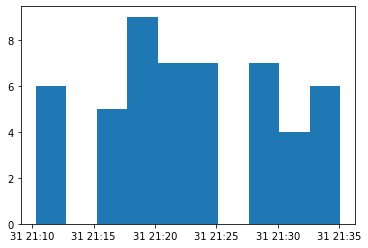

In [22]:
plt.hist(time_third)

In [23]:
date_third = time_third.apply(lambda x: x.date())
date_third.value_counts()

2000-12-31    51
Name: Time, dtype: int64

In [24]:
time_third[:50]

0    2000-12-31 21:10:18
1    2000-12-31 21:10:39
2    2000-12-31 21:11:08
3    2000-12-31 21:11:08
4    2000-12-31 21:11:35
5    2000-12-31 21:11:35
6    2000-12-31 21:16:36
7    2000-12-31 21:16:59
8    2000-12-31 21:16:59
9    2000-12-31 21:16:59
10   2000-12-31 21:17:19
11   2000-12-31 21:18:32
12   2000-12-31 21:18:59
13   2000-12-31 21:18:59
14   2000-12-31 21:19:30
15   2000-12-31 21:19:30
16   2000-12-31 21:19:30
17   2000-12-31 21:20:00
18   2000-12-31 21:20:00
19   2000-12-31 21:20:00
20   2000-12-31 21:21:03
21   2000-12-31 21:21:03
22   2000-12-31 21:21:30
23   2000-12-31 21:21:50
24   2000-12-31 21:22:37
25   2000-12-31 21:22:37
26   2000-12-31 21:22:37
27   2000-12-31 21:22:57
28   2000-12-31 21:22:57
29   2000-12-31 21:23:25
30   2000-12-31 21:23:57
31   2000-12-31 21:23:57
32   2000-12-31 21:24:27
33   2000-12-31 21:24:27
34   2000-12-31 21:27:59
35   2000-12-31 21:28:23
36   2000-12-31 21:29:07
37   2000-12-31 21:29:07
38   2000-12-31 21:29:07
39   2000-12-31 21:29:26


세번 째 User는 대략 30분동안 하루 안에 모든 리뷰를 올린 케이스이다. 세 User의 시간에 리뷰 입력 양상을 분석해보면, 하루 안에 입력 리뷰는 거의 한번에 연속으로 올린 것이었다. 또한 여러 날짜에 리뷰를 올린 User도 각 날짜에 한번에 리뷰를 올렸다. 이런 점을 보았을 때, Session을 유저가 리뷰를 올린 날짜로 각 Session으로 정의하는 것이 바람직해 보인다. 

In [25]:
data['Date']=data['Time'].apply(lambda x: x.date())
data.head()

,index,UserId,ItemId,Rating,Time,Date
0,31,1,3186,4,2000-12-31 22:00:19,2000-12-31
1,22,1,1270,5,2000-12-31 22:00:55,2000-12-31
2,27,1,1721,4,2000-12-31 22:00:55,2000-12-31
3,37,1,1022,5,2000-12-31 22:00:55,2000-12-31
4,24,1,2340,3,2000-12-31 22:01:43,2000-12-31


In [26]:
data.head()

,index,UserId,ItemId,Rating,Time,Date
0,31,1,3186,4,2000-12-31 22:00:19,2000-12-31
1,22,1,1270,5,2000-12-31 22:00:55,2000-12-31
2,27,1,1721,4,2000-12-31 22:00:55,2000-12-31
3,37,1,1022,5,2000-12-31 22:00:55,2000-12-31
4,24,1,2340,3,2000-12-31 22:01:43,2000-12-31


In [27]:
session_index = data.groupby(['UserId', 'Date'])['Time'].count()
session_index

UserId  Date      
1       2000-12-31     40
        2001-01-06     13
2       2000-12-31    129
3       2000-12-31     51
4       2000-12-31     21
                     ... 
6040    2000-07-28     13
        2000-07-29      1
        2001-03-10      1
        2001-08-10     21
        2001-08-20      1
Name: Time, Length: 22814, dtype: int64

In [28]:
n= 0
sessions=[]
for session in session_index:
    n+=1
    #print(session)
    sessions.extend([n]*session)
sessions[:42]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2]

In [29]:
data['SessionId'] = pd.Series(sessions)
data.head(42)

,index,UserId,ItemId,Rating,Time,Date,SessionId
0,31,1,3186,4,2000-12-31 22:00:19,2000-12-31,1
1,22,1,1270,5,2000-12-31 22:00:55,2000-12-31,1
2,27,1,1721,4,2000-12-31 22:00:55,2000-12-31,1
3,37,1,1022,5,2000-12-31 22:00:55,2000-12-31,1
4,24,1,2340,3,2000-12-31 22:01:43,2000-12-31,1
5,36,1,1836,5,2000-12-31 22:02:52,2000-12-31,1
6,3,1,3408,4,2000-12-31 22:04:35,2000-12-31,1
7,7,1,2804,5,2000-12-31 22:11:59,2000-12-31,1
8,47,1,1207,4,2000-12-31 22:11:59,2000-12-31,1
9,0,1,1193,5,2000-12-31 22:12:40,2000-12-31,1


In [30]:
data.tail()

,index,UserId,ItemId,Rating,Time,Date,SessionId
1000204,1000019,6040,2917,4,2001-08-10 14:40:29,2001-08-10,22813
1000205,999988,6040,1921,4,2001-08-10 14:41:04,2001-08-10,22813
1000206,1000172,6040,1784,3,2001-08-10 14:41:04,2001-08-10,22813
1000207,1000167,6040,161,3,2001-08-10 14:41:26,2001-08-10,22813
1000208,1000042,6040,1221,4,2001-08-20 13:44:15,2001-08-20,22814


SessionId가 바르게 만들어진 것을 확인할 수 있다. 

### Session Length

In [31]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
22810     13
22811      1
22812      1
22813     21
22814      1
Length: 22814, dtype: int64

In [32]:
session_length.median(), session_length.mean()

(7.0, 43.84189532743053)

In [33]:
session_length.min(), session_length.max()

(1, 1442)

In [34]:
session_length.quantile(0.999)

794.1870000000017

In [35]:
long_session = session_length[session_length==1442].index[0]
data[data['SessionId']==long_session]

,index,UserId,ItemId,Rating,Time,Date,SessionId
137560,137631,889,1266,3,2000-11-26 14:11:02,2000-11-26,3269
137561,137864,889,2430,3,2000-11-26 14:11:02,2000-11-26,3269
137562,137889,889,1643,3,2000-11-26 14:11:02,2000-11-26,3269
137563,138039,889,3461,3,2000-11-26 14:11:02,2000-11-26,3269
137564,138316,889,1193,1,2000-11-26 14:11:02,2000-11-26,3269
...,...,...,...,...,...,...,...
138997,138442,889,1543,1,2000-11-26 18:04:11,2000-11-26,3269
138998,138211,889,617,3,2000-11-26 18:04:24,2000-11-26,3269
138999,138215,889,476,2,2000-11-26 18:04:24,2000-11-26,3269
139000,138394,889,844,3,2000-11-26 18:04:39,2000-11-26,3269


In [36]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.262383
2      0.366310
3      0.418077
4      0.449812
5      0.477119
         ...   
779    0.998817
781    0.998860
786    0.998904
792    0.998948
794    0.998992
Length: 573, dtype: float64

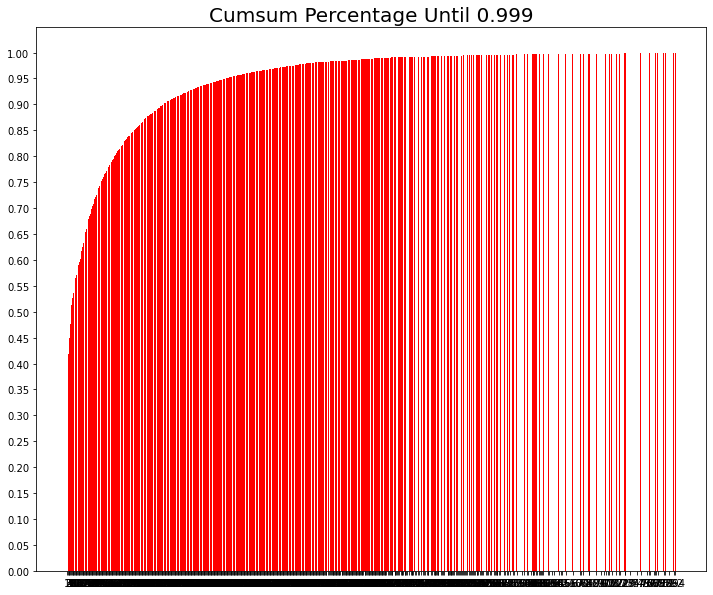

In [37]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

In [38]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [39]:
month_order = []
for i in range(2000,2004):
    for j in range(1,13):
        month_order.append(f'{i}-{j}')
month_order=month_order[3:-10]
month_order

['2000-4',
 '2000-5',
 '2000-6',
 '2000-7',
 '2000-8',
 '2000-9',
 '2000-10',
 '2000-11',
 '2000-12',
 '2001-1',
 '2001-2',
 '2001-3',
 '2001-4',
 '2001-5',
 '2001-6',
 '2001-7',
 '2001-8',
 '2001-9',
 '2001-10',
 '2001-11',
 '2001-12',
 '2002-1',
 '2002-2',
 '2002-3',
 '2002-4',
 '2002-5',
 '2002-6',
 '2002-7',
 '2002-8',
 '2002-9',
 '2002-10',
 '2002-11',
 '2002-12',
 '2003-1',
 '2003-2']

Text(0, 0.5, 'Count')

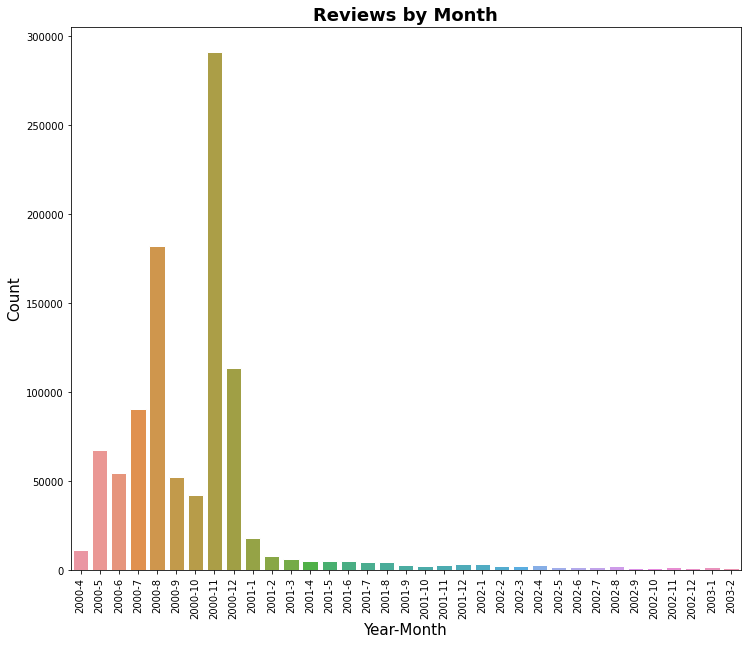

In [40]:
data['Year']=data['Time'].apply(lambda x: f"{x.year}-{x.month}")
countplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='Year', data=data, order=month_order)
plt.xticks(rotation='vertical')
ax.set_title('Reviews by Month',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year-Month', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)

데이터가 애초에 약 20년이 지난 것이기 때문에 최근 데이터를 이용한다고 크게 바뀌는 것이 없을 것으로 보이며 또한 후반에 데이터의 양이 많이 줄어들기 때문에 데이터 전체를 이용하기로 한다.

### Rating 낮은 데이터 처리

실제로 rating이 높은 경우만 마음에 들었다는 것으로 해석할 수 있는데, 영화를 추천하는 것이 목표이기 때문에 rating이 3 이하인 경우는 모두 제거하고 진행하겠다.

In [41]:
data=data[data['Rating']>3]
data

,index,UserId,ItemId,Rating,Time,Date,SessionId,Year
0,31,1,3186,4,2000-12-31 22:00:19,2000-12-31,1,2000-12
1,22,1,1270,5,2000-12-31 22:00:55,2000-12-31,1,2000-12
2,27,1,1721,4,2000-12-31 22:00:55,2000-12-31,1,2000-12
3,37,1,1022,5,2000-12-31 22:00:55,2000-12-31,1,2000-12
5,36,1,1836,5,2000-12-31 22:02:52,2000-12-31,1,2000-12
...,...,...,...,...,...,...,...,...
1000202,1000119,6040,3671,4,2001-08-10 14:39:27,2001-08-10,22813,2001-8
1000203,999923,6040,232,5,2001-08-10 14:39:58,2001-08-10,22813,2001-8
1000204,1000019,6040,2917,4,2001-08-10 14:40:29,2001-08-10,22813,2001-8
1000205,999988,6040,1921,4,2001-08-10 14:41:04,2001-08-10,22813,2001-8


데이터가 절반 정도로 줄어든 것을 확인할 수 있다. 

### Data Cleansing

In [42]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [43]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,index,UserId,ItemId,Rating,Time,Date,SessionId,Year
0,31,1,3186,4,2000-12-31 22:00:19,2000-12-31,1,2000-12
1,22,1,1270,5,2000-12-31 22:00:55,2000-12-31,1,2000-12
2,27,1,1721,4,2000-12-31 22:00:55,2000-12-31,1,2000-12
3,37,1,1022,5,2000-12-31 22:00:55,2000-12-31,1,2000-12
5,36,1,1836,5,2000-12-31 22:02:52,2000-12-31,1,2000-12
...,...,...,...,...,...,...,...,...
1000201,1000118,6040,457,4,2001-08-10 14:39:09,2001-08-10,22813,2001-8
1000202,1000119,6040,3671,4,2001-08-10 14:39:27,2001-08-10,22813,2001-8
1000203,999923,6040,232,5,2001-08-10 14:39:58,2001-08-10,22813,2001-8
1000204,1000019,6040,2917,4,2001-08-10 14:40:29,2001-08-10,22813,2001-8


### Train / Valid / Test split

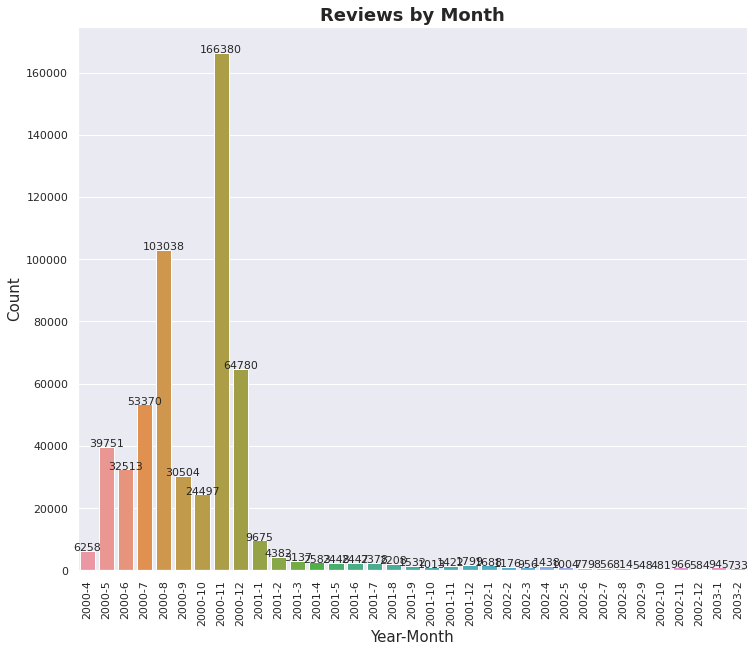

In [44]:
data['Year']=data['Time'].apply(lambda x: f"{x.year}-{x.month}")
countplt, ax = plt.subplots(figsize=(12,10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='Year', data=data, order=month_order)
plt.xticks(rotation='vertical')
ax.set_title('Reviews by Month',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year-Month', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize =11)

후반의 데이터가 양이 굉장히 적기 때문에 valid와 test set을 마지막 16개월을 각각 대략 10개월과 6개월로 나누어서 구성하겠다. 

In [45]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [46]:
tr, test = split_by_date(data, n_days=30*10)
tr, val = split_by_date(tr, n_days=30*6)

In [47]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [48]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 553103
	 Sessions: 12771
	 Items: 3115
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-11-05 00:09:19

* valid Set Stats Info
	 Events: 8374
	 Sessions: 744
	 Items: 1984
	 First Time : 2001-11-05 04:04:02
	 Last Time : 2002-05-04 02:01:59

* test Set Stats Info
	 Events: 7594
	 Sessions: 790
	 Items: 1890
	 First Time : 2002-05-04 09:26:12
	 Last Time : 2003-02-28 17:49:50



In [49]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [50]:
save_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/processed_ex')
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 미니 배치 구성

In [51]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [52]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,index,UserId,ItemId,Rating,Time,Date,SessionId,Year,item_idx
0,31,1,3186,4,2000-12-31 22:00:19,2000-12-31,1,2000-12,0
1,22,1,1270,5,2000-12-31 22:00:55,2000-12-31,1,2000-12,1
2,27,1,1721,4,2000-12-31 22:00:55,2000-12-31,1,2000-12,2
3,37,1,1022,5,2000-12-31 22:00:55,2000-12-31,1,2000-12,3
5,36,1,1836,5,2000-12-31 22:02:52,2000-12-31,1,2000-12,4
6,3,1,3408,4,2000-12-31 22:04:35,2000-12-31,1,2000-12,5
7,7,1,2804,5,2000-12-31 22:11:59,2000-12-31,1,2000-12,6
8,47,1,1207,4,2000-12-31 22:11:59,2000-12-31,1,2000-12,7
9,0,1,1193,5,2000-12-31 22:12:40,2000-12-31,1,2000-12,8
11,44,1,260,4,2000-12-31 22:12:40,2000-12-31,1,2000-12,9


In [53]:
tr_dataset.click_offsets

array([     0,     34,     45, ..., 553077, 553086, 553103], dtype=int32)

In [54]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 12768, 12769, 12770])

In [55]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [56]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,index,UserId,ItemId,Rating,Time,Date,SessionId,Year,item_idx
0,31,1,3186,4,2000-12-31 22:00:19,2000-12-31,1,2000-12,0
1,22,1,1270,5,2000-12-31 22:00:55,2000-12-31,1,2000-12,1
2,27,1,1721,4,2000-12-31 22:00:55,2000-12-31,1,2000-12,2
3,37,1,1022,5,2000-12-31 22:00:55,2000-12-31,1,2000-12,3
5,36,1,1836,5,2000-12-31 22:02:52,2000-12-31,1,2000-12,4
6,3,1,3408,4,2000-12-31 22:04:35,2000-12-31,1,2000-12,5
7,7,1,2804,5,2000-12-31 22:11:59,2000-12-31,1,2000-12,6
8,47,1,1207,4,2000-12-31 22:11:59,2000-12-31,1,2000-12,7
9,0,1,1193,5,2000-12-31 22:12:40,2000-12-31,1,2000-12,8
11,44,1,260,4,2000-12-31 22:12:40,2000-12-31,1,2000-12,9


In [57]:
iter_ex = iter(tr_data_loader)

In [58]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 34 45 52]
Label Item Idx are :       [  1  35  46 112]
Previous Masked Input Idx are []


## 모델 구성
### Evaluation Metric

In [59]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [60]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [61]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [62]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3115)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      475050    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3115)                158865    
Total params: 633,915
Trainable params: 633,915
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [63]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [64]:
train_model(model, args)

Evaluation:  81%|████████  | 96/119 [00:35<00:08,  2.71it/s]


	 - Recall@20 epoch 1: 0.135905
	 - MRR@20    epoch 1: 0.032313



Evaluation:  81%|████████  | 96/119 [00:33<00:08,  2.83it/s]


	 - Recall@20 epoch 2: 0.169922
	 - MRR@20    epoch 2: 0.045087



Evaluation:  81%|████████  | 96/119 [00:33<00:08,  2.87it/s]


	 - Recall@20 epoch 3: 0.183757
	 - MRR@20    epoch 3: 0.049334



Evaluation:  81%|████████  | 96/119 [00:32<00:07,  2.92it/s]


	 - Recall@20 epoch 4: 0.189616
	 - MRR@20    epoch 4: 0.052479



Evaluation:  81%|████████  | 96/119 [00:33<00:08,  2.85it/s]

	 - Recall@20 epoch 5: 0.191243
	 - MRR@20    epoch 5: 0.054860



## Inference

In [65]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  80%|████████  | 85/106 [00:31<00:07,  2.74it/s]

	 - Recall@20: 0.169118
	 - MRR@20: 0.048138



## 2번째 시도
* batch size 64->128로 조정

In [66]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [67]:
model2 = create_model(args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3115)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    475050    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3115)               158865    
Total params: 633,915
Trainable params: 633,915
Non-trainable params: 0
_________________________________________________________________


In [68]:
train_model(model2, args2)

Evaluation:  64%|██████▍   | 38/59 [00:26<00:14,  1.43it/s]


	 - Recall@20 epoch 1: 0.108347
	 - MRR@20    epoch 1: 0.027715



Evaluation:  64%|██████▍   | 38/59 [00:25<00:14,  1.47it/s]


	 - Recall@20 epoch 2: 0.161801
	 - MRR@20    epoch 2: 0.043953



Evaluation:  64%|██████▍   | 38/59 [00:25<00:13,  1.52it/s]


	 - Recall@20 epoch 3: 0.177220
	 - MRR@20    epoch 3: 0.048180



Evaluation:  64%|██████▍   | 38/59 [00:24<00:13,  1.54it/s]


	 - Recall@20 epoch 4: 0.186883
	 - MRR@20    epoch 4: 0.051159



Evaluation:  64%|██████▍   | 38/59 [00:24<00:13,  1.53it/s]

	 - Recall@20 epoch 5: 0.190584
	 - MRR@20    epoch 5: 0.054342



In [69]:
test_model(model2, args2, test)

Evaluation:  62%|██████▏   | 33/53 [00:21<00:13,  1.52it/s]

	 - Recall@20: 0.159801
	 - MRR@20: 0.046654



## 회고

* batch size를 낮추니 전반적으로 더 낮은 성능을 보였다  
* 현재 노트북에서는 epoch가 5로 설정되어 있지만, 이는 실험 끝에 5 epoch 이상 돌리면 오버피팅이 일어나는 것을 확인하고 설정한 것이다.  
* 사실 데이터의 전처리 부분까지는 잘 알겠는데, 모델이 어떤 원리로 어떤 식으로 학습이 되는지 정확하게 파악하지는 못한 것 같다. 추후에 추가적으로 공부할 필요가 있을 것 같다. 
* 추천 시스템은 나랑 잘 맞지 않는 것 같다. 